# 'N' queens puzzle
---
Description:

- Optimization (combinatorial)
- Single-objective
- Constraints (yes)
---

The 'N' queens puzzle is the problem of placing eight chess queens on an N×N chessboard so that no two queens
threaten each other; thus, a solution requires that no two queens share the same row, column, or diagonal. 

An example for N=8 can be found here: https://en.wikipedia.org/wiki/Eight_queens_puzzle

### First we import python libraries and set up the directory of our code.

In [19]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

### Here we import all our custom GA code.

In [20]:
# Import main classes.
from pygenalgo.genome.gene import Gene
from pygenalgo.genome.chromosome import Chromosome
from pygenalgo.utils.utilities import cost_function
from pygenalgo.engines.island_model_ga import IslandModelGA

# Import Selection Operator(s).
from pygenalgo.operators.selection.linear_rank_selector import LinearRankSelector

# Import Crossover Operator(s).
from pygenalgo.operators.crossover.single_point_crossover import SinglePointCrossover

# Import Mutation Operator(s).
from pygenalgo.operators.mutation.swap_mutator import SwapMutator

# Import Migration Operator(s).
from pygenalgo.operators.migration.clockwise_migration import ClockwiseMigration

In [21]:
# Define the fitness function.
@cost_function(minimize=True)
def fun_Queens(individual: Chromosome, n_queen: int = 8):
    """
    This function counts the number of violations in the positions of the queens
    on the chessboard. We check horizontally, vertically and diagonally.
    """

    # Reshape the chromosome into a 2D array.
    chess_board = np.reshape(individual.values(), (n_queen, n_queen))
    
    # Sum the entries row-wise.
    sum_row = np.sum(chess_board, axis=0)

    # Sum the entries column-wise.
    sum_col = np.sum(chess_board, axis=1)

    # Compute limits of the diagonal test.
    low = -n_queen + 2
    high = n_queen - 1

    # Sum the entries diagonally.
    sum_diag = []
    for k in range(low, high):
        sum_diag.append(sum(np.diag(chess_board, k)))
    # _end_for_

    # We flip to count the violations in the anti-diagonal way.
    flip_arr = np.flip(chess_board, axis=1)
    sum_flip = []
    
    # Sum the entries anti-diagonally.
    for k in range(low, high):
        sum_flip.append(sum(np.diag(flip_arr, k)))
    # _end_for_

    # Count the total violations.
    f_value = 0.0

    for i, j in zip(sum_row, sum_col):
        f_value += max(i - 1, 0)
        f_value += max(j - 1, 0)
    # _end_for_
    
    for k, l in zip(sum_diag, sum_flip):
        f_value += max(k - 1, 0)
        f_value += max(l - 1, 0)
    # _end_for_

    # Condition for termination.
    solution_found = f_value == 0
    
    # Return the solution tuple.
    return f_value, solution_found
# _end_def_

## Important note

Similar to the TSP problem, here we would require special crossover operator for permutations, in order to avoid creating 
invalid offsprings. Otherwise the number of queens on the board could be higher (or less) than 'N'.

The way we can bypass this hard constraint here, with our current implementation, is to set the crossover operator (any of 
them) with zero probability (i.e. probability=0.0). At the same time, to ensure that the new offsprings will be modified we 
set the mutation probability to 0.8 (i.e 80%). The mutation operators that are suitable for these types of problems are the: 
SwapMutator and ShuffleMutator.

In [22]:
# Set a random generator.
rng = np.random.default_rng()

# Random function: Return a random (0, 1).
rand_fc = lambda: rng.integers(0, 1, endpoint=True)

# The number of queens can be parameterized.
n_queen = 8

# Make sure they are at least '4'.
n_queen = max(n_queen, 4)

# Define the number of chromosomes.
N = 200

# Initial population.
population = []

for i in range(N):
    
    arr = np.zeros(n_queen*n_queen)
    
    arr[np.random.permutation(n_queen*n_queen)[:n_queen]] = 1.0
    
    population.append(Chromosome([Gene(c, rand_fc) for c in arr.tolist()],
                                 np.nan, True))
# _end_for_

# Create the IslandModelGA object that will carry on the optimization.
test_GA = IslandModelGA(initial_pop=population,
                        fit_func=lambda x: fun_Queens(x, n_queen=n_queen),
                        num_islands=4,
                        select_op=LinearRankSelector(),
                        mutate_op=SwapMutator(0.8),
                        crossx_op=SinglePointCrossover(0.0),
                        migrate_op=ClockwiseMigration())

## Plot a random initial configuration.

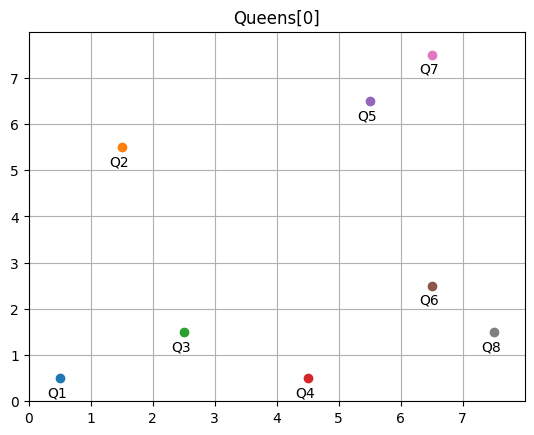

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

arr = [g.value for g in population[0].genome]

x_coord, y_coord = np.nonzero(np.reshape(arr, (n_queen, n_queen)))

for i, (x, y) in enumerate(zip(x_coord, y_coord), start=1):
    ax.plot(x+0.5, y+0.5, 'o')
    ax.annotate(f'Q{i}', xy=(x+0.3, y+0.1))
# _end_for_

ax.grid()

ax.set_xlim([0, n_queen])
ax.set_ylim([0, n_queen])

ax.set(xticks=range(0, n_queen, 1),
       yticks=range(0, n_queen, 1))

plt.title("Queens[0]")

plt.show()

In [24]:
test_GA(epochs=500, elitism=True, allow_migration=False, verbose=True)

Parallel evolution in progress with 4 islands ...
Island population 0, finished in 229 iterations.
Island population 3, finished in 247 iterations.
Final Avg. Fitness = -1.6350.
Elapsed time: 9.679 seconds.


### Display the final (optimal) solution.

In [25]:
# Extract the optimal solution from the GA.
optimal_solution = test_GA.best_chromosome()

# Extract the fitness value from the optimal solution.
optimal_fit = -optimal_solution.fitness

# Display the (final) optimal value.
print(f"Optimal configuration found: {optimal_fit:.5f}\n")

# Display the positions of the queens.
sol_chess_board = np.reshape(optimal_solution.values(), (n_queen, n_queen))

print(sol_chess_board)

# NOTE: The absolute minimum is 0.0.

Optimal configuration found: 0.00000

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


## Plot the optimal solution.

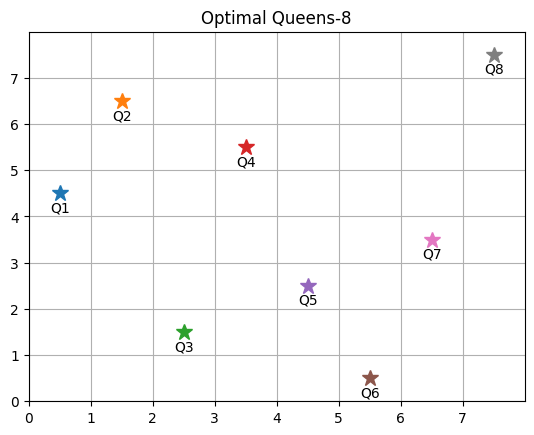

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)

x_coord, y_coord = np.nonzero(sol_chess_board)

for i, (x, y) in enumerate(zip(x_coord, y_coord), start=1):
    ax.plot(x+0.5, y+0.5, '*', markersize=12)
    ax.annotate(f'Q{i}', xy=(x+0.35, y+0.1))
# _end_for_

ax.grid()

ax.set_xlim([0, n_queen])
ax.set_ylim([0, n_queen])

ax.set(xticks=range(0, n_queen, 1),
       yticks=range(0, n_queen, 1))

plt.title(f"Optimal Queens-{n_queen}")

plt.show()

### End of file